In [21]:
from random import random
from typing import List
import re
def load_all_names() -> List[str]:
    # Task 1: Load all names and lower-case them
    result = []
    with open('names.txt', 'rt', encoding='utf-8') as f:
        all_lines: List[str] = f.readlines()
        for line in all_lines:
            m = re.match(r':\[\[(\w+?)\]\]', line)
            if m:
                name = m.group(1).lower()
                result.append(name)
            #if line.startswith(':[['):
            #    result.append(line.strip().replace(':[[', '').replace(']]', '').lower())
    
    return result

all_names = load_all_names()
print(all_names[:20])
print(len(all_names))

['aaron', 'abbe', 'abbo', 'abi', 'abilo', 'abo', 'abraham', 'achatius', 'achaz', 'achill', 'achilles', 'achim', 'adalar', 'adalbald', 'adalbert', 'adalbod', 'adalbold', 'adalbrand', 'adalbrecht', 'adaldag']
5273


In [22]:
# Just exploring character bi-gram counts
b = {}
for w in all_names:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

# sort by value, reverse
sorted(b.items(), key = lambda kv: -kv[1])

[(('a', '<E>'), 1167),
 (('i', 'n'), 816),
 (('e', 'r'), 792),
 (('e', '<E>'), 790),
 (('d', '<E>'), 738),
 (('a', 'r'), 732),
 (('r', 'i'), 641),
 (('a', 'n'), 620),
 (('<S>', 'a'), 536),
 (('e', 'l'), 523),
 (('a', 'l'), 475),
 (('i', 'l'), 465),
 (('d', 'e'), 454),
 (('s', '<E>'), 447),
 (('t', '<E>'), 422),
 (('l', 'i'), 405),
 (('l', 'd'), 396),
 (('n', 'a'), 396),
 (('n', '<E>'), 393),
 (('i', 'e'), 388),
 (('<S>', 'h'), 385),
 (('r', 'a'), 372),
 (('r', 't'), 365),
 (('u', 's'), 361),
 (('<S>', 'e'), 353),
 (('m', 'a'), 348),
 (('h', 'e'), 338),
 (('b', 'e'), 337),
 (('n', 'd'), 332),
 (('<S>', 'r'), 327),
 (('<S>', 's'), 326),
 (('r', '<E>'), 323),
 (('e', 'n'), 319),
 (('n', 'e'), 317),
 (('<S>', 'g'), 317),
 (('o', 'l'), 312),
 (('h', 'a'), 310),
 (('r', 'e'), 302),
 (('o', 'r'), 302),
 (('l', 'a'), 300),
 (('<S>', 'b'), 294),
 (('i', 'a'), 291),
 (('<S>', 'l'), 287),
 (('r', 'd'), 280),
 (('t', 'h'), 276),
 (('<S>', 'w'), 274),
 (('o', '<E>'), 267),
 (('<S>', 'm'), 254),
 ((

In [23]:
from typing import Set

# Task 2: construct bigram counts tensor


# All characters + one special character "." for both BOS and EOS

all_chars: List[str] = ['.']

for name in all_names:
    all_chars.extend(list(name))

chars = sorted(list(set(all_chars)))
print(chars)
print(len(chars))


['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'ä', 'ô', 'ö', 'ø', 'ü']
33


In [26]:
from typing import Dict

# string to index, index to string
str_to_idx: Dict[str, int] = dict()
idx_to_str: Dict[int, str] = dict()

for i, char in enumerate(chars):
    str_to_idx[char] = i
    idx_to_str[i] = char

print(str_to_idx)
print(idx_to_str)
assert str_to_idx['.'] == 0
assert idx_to_str[32] == 'ü'


{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'ß': 27, 'ä': 28, 'ô': 29, 'ö': 30, 'ø': 31, 'ü': 32}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'ß', 28: 'ä', 29: 'ô', 30: 'ö', 31: 'ø', 32: 'ü'}


What we want to do?

```plain
  + . | a | b | c | ..... | ü |
. |     x
a |
b |
c |         y
d |
.
ü |

x = how many times a followed .
y = how many times b followed c



    0 | 1 | 2 | 3 | ..... | 32 |
0 |     x
1 |
2 |
3 |         y
4 |
.
32 |
```

In [34]:
import torch
bigram_count_matrix = torch.ones((len(chars), len(chars)), dtype=torch.int)

for current_name in all_names:
    list_of_chars = ['.'] + list(current_name) + ['.']
    for i in range(1, len(list_of_chars)):
        ch1: str = list_of_chars[i - 1]
        ch2: str = list_of_chars[i]
        index_of_ch1 = str_to_idx[ch1]
        index_of_ch2 = str_to_idx[ch2]
        bigram_count_matrix[index_of_ch1, index_of_ch2] += 1
    # for ch1, ch2 in zip(list_of_chars, list_of_chars[1:]):
    #    bigram = (ch1, ch2)
    #    b[bigram] = b.get(bigram, 0) + 1


print(bigram_count_matrix)
print(bigram_count_matrix.shape)


tensor([[   1,  537,  295,  ...,    1,    1,    1],
        [1168,    9,   47,  ...,    1,    1,    1],
        [  17,  111,   13,  ...,    1,    1,    1],
        ...,
        [   1,    1,    2,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], dtype=torch.int32)
torch.Size([33, 33])


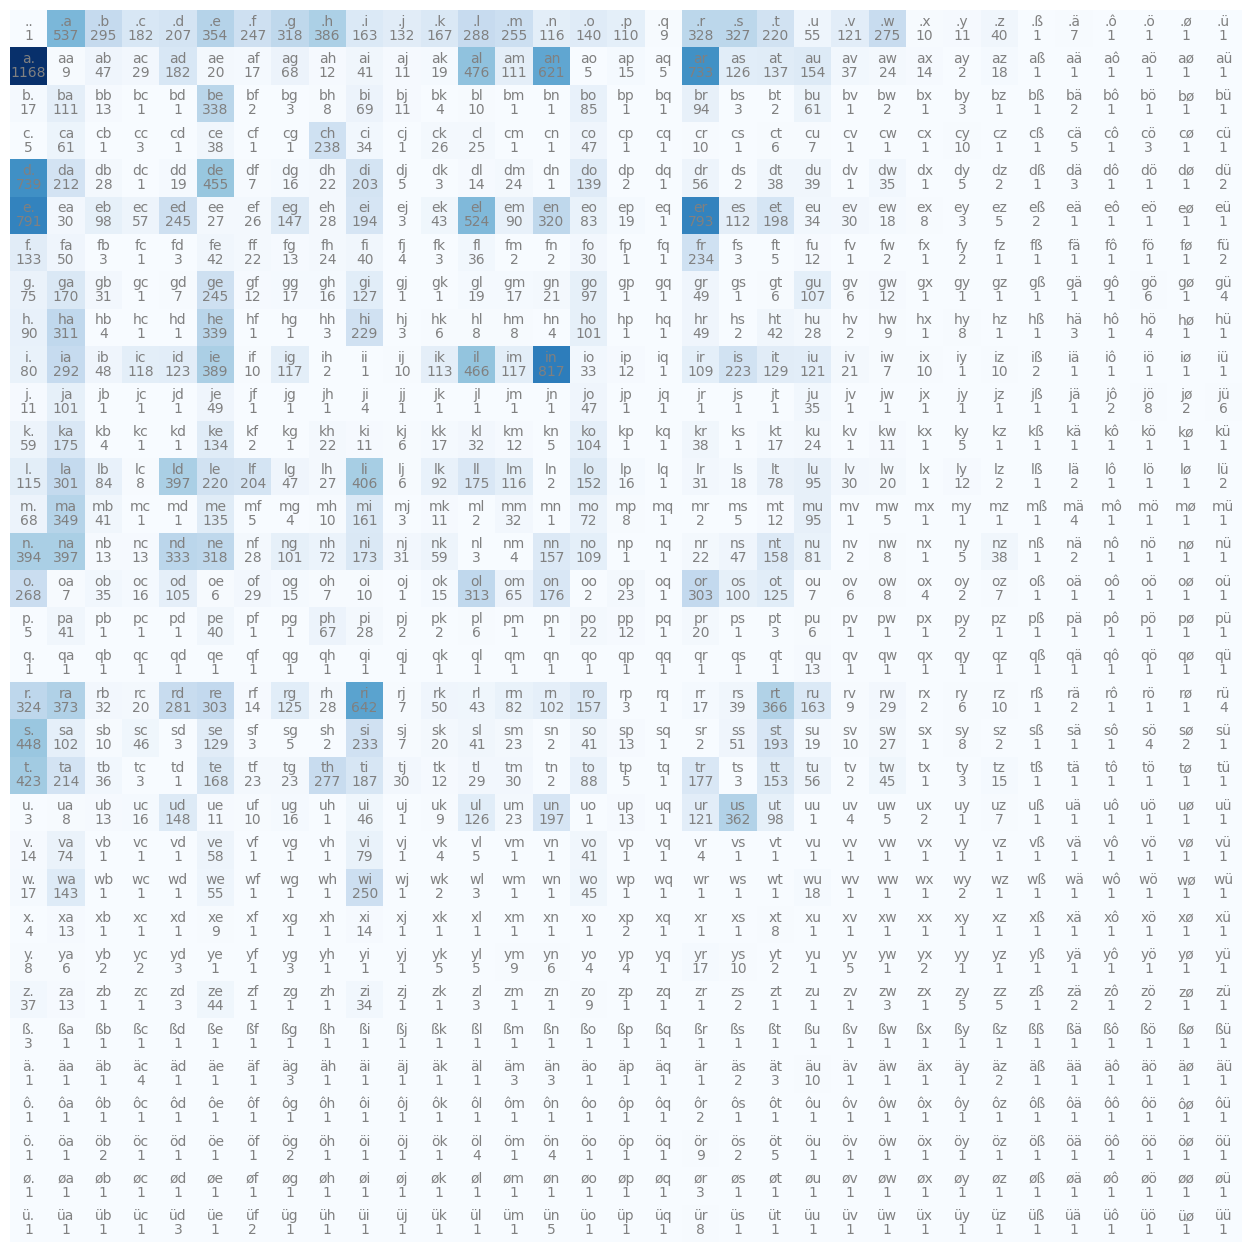

In [35]:
# Visualise bigram count matrix
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(bigram_count_matrix, cmap='Blues')
for i in range(len(chars)):
    for j in range(len(chars)):
        chstr = idx_to_str[i] + idx_to_str[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, bigram_count_matrix[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

Bi-gram character language model

We need $\Pr[C_2 = . | C_1 = .]$

We need $\Pr[C_2 = a | C_1 = .]$

We need $\Pr[C_2 = b | C_1 = .]$

We need $\Pr[C_2 = c | C_1 = .]$

We need $\Pr[C_2 = d | C_1 = .]$

We need $\Pr[C_2 = \ldots | C_1 = .]$

We need $\Pr[C_2 = . | C_1 = a]$

We need $\Pr[C_2 = a | C_1 = a]$

We need $\Pr[C_2 = b | C_1 = a]$

We need $\Pr[C_2 = c | C_1 = a]$

We need $\Pr[C_2 = d | C_1 = a]$

We need $\Pr[C_2 = \ldots | C_1 = a]$


* We need to "normalize" each row by
    * Get a sum of the $i$-th row
    * Divide all items in the $i$-the row by the sum



In [36]:
# Task 3: Create bigram conditional probability matrix

# First do it for the first row and sample the first character

sum_of_rows = bigram_count_matrix.sum(dim=1, keepdim=True)
print(sum_of_rows)
p = bigram_count_matrix / sum_of_rows
p

tensor([[5306],
        [4107],
        [ 852],
        [ 536],
        [2079],
        [3934],
        [ 678],
        [1057],
        [1265],
        [3387],
        [ 288],
        [ 693],
        [2664],
        [1037],
        [2576],
        [1662],
        [ 275],
        [  45],
        [3238],
        [1452],
        [2013],
        [1250],
        [ 304],
        [ 559],
        [  77],
        [ 109],
        [ 182],
        [  35],
        [  55],
        [  34],
        [  54],
        [  35],
        [  47]])


tensor([[1.8847e-04, 1.0121e-01, 5.5597e-02,  ..., 1.8847e-04, 1.8847e-04,
         1.8847e-04],
        [2.8439e-01, 2.1914e-03, 1.1444e-02,  ..., 2.4349e-04, 2.4349e-04,
         2.4349e-04],
        [1.9953e-02, 1.3028e-01, 1.5258e-02,  ..., 1.1737e-03, 1.1737e-03,
         1.1737e-03],
        ...,
        [1.8519e-02, 1.8519e-02, 3.7037e-02,  ..., 1.8519e-02, 1.8519e-02,
         1.8519e-02],
        [2.8571e-02, 2.8571e-02, 2.8571e-02,  ..., 2.8571e-02, 2.8571e-02,
         2.8571e-02],
        [2.1277e-02, 2.1277e-02, 2.1277e-02,  ..., 2.1277e-02, 2.1277e-02,
         2.1277e-02]])

In [44]:
# Task 4: Generate random "names"
g = torch.Generator().manual_seed(41)


for i in range(50):
    out = ['.']
    next_char = ''
    while next_char != '.':
        # get the last generated character
        previous_char = out[-1]
        # get cond. prob. dist for previous_char
        index_of_previous_char = str_to_idx[previous_char]
        row_from_cond_prob_matrix = p[index_of_previous_char]
        # print(row_from_cond_prob_matrix) 
        index_of_next_char = torch.multinomial(row_from_cond_prob_matrix, 1, generator=g)
        # turn the sampled number to an actual character
        next_char = idx_to_str[int(index_of_next_char)]
        # print("Previous char was: " + previous_char, ", sampled next character is: " + next_char)
        # add to the result
        out.append(next_char)

    print(''.join(out))



.hirinetapalirkar.
.d.
.a.
.rd.
.llta.
.arsit.
.be.
.bietth.
.e.
.nilekebrgud.
.leabonald.
.oler.
.caridta.
.mant.
.rne.
.theiusclece.
.junhenondind.
.silemalvot.
.abaiana.
.f.
.frodhelmkajulfrurackutachollfielkkarisanna.
.wieldetrkrure.
.elot.
.jörnus.
.enelgerentunambed.
.mand.
.tlharuricha.
.ttied.
.frd.
.strededens.
.eobrkma.
.a.
.bre.
.ldevinia.
.tolt.
.sonotr.
.garanend.
.jolibrte.
.nfand.
.heilketlolelmtinet.
.a.
.lin.
.ausvinin.
.pinelolloli.
.gmid.
.eötina.
.egönaderdrd.
.eia.
.sell.
.hen.


In [ ]:
# Task 5: Create a 3-gram langauge model on words (get a clean text corpus, e.g., Project Gutenberg)
# and generate some text